## Модели прогнозирования объема убоя КРС по ВКО

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Подготовка данных и EDA

In [2]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.head(5)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


In [4]:
df_vko = df[df['Регион'] == 'ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ']
df_vko = df_vko.drop('Регион', axis = 'columns')
df_vko.head()

,Период,КРС,Осадки,Поголовье: КРС,Температура
480,2015-01,4151.27,29.4,786783.0,-10.364516
481,2015-02,6473.64,33.4,860746.0,-9.839286
482,2015-03,6837.39,41.2,939284.0,-4.858065
483,2015-04,5875.35,50.6,1013296.0,6.830000
484,2015-05,5952.33,63.8,1046072.0,14.774194


In [5]:
df_vko = df_vko.rename(columns={'КРС': 'Объем убоя: КРС'})
df_vko.head()

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
480,2015-01,4151.27,29.4,786783.0,-10.364516
481,2015-02,6473.64,33.4,860746.0,-9.839286
482,2015-03,6837.39,41.2,939284.0,-4.858065
483,2015-04,5875.35,50.6,1013296.0,6.830000
484,2015-05,5952.33,63.8,1046072.0,14.774194


In [6]:
df_vko['Период'] = pd.to_datetime(df_vko['Период'], format='%Y-%m')

In [7]:
df_vko.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 480 to 599
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           120 non-null    datetime64[ns]
 1   Объем убоя: КРС  120 non-null    float64       
 2   Осадки           120 non-null    float64       
 3   Поголовье: КРС   120 non-null    float64       
 4   Температура      120 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.6 KB


In [8]:
df_vko.isna().sum()

Период             0
Объем убоя: КРС    0
Осадки             0
Поголовье: КРС     0
Температура        0
dtype: int64

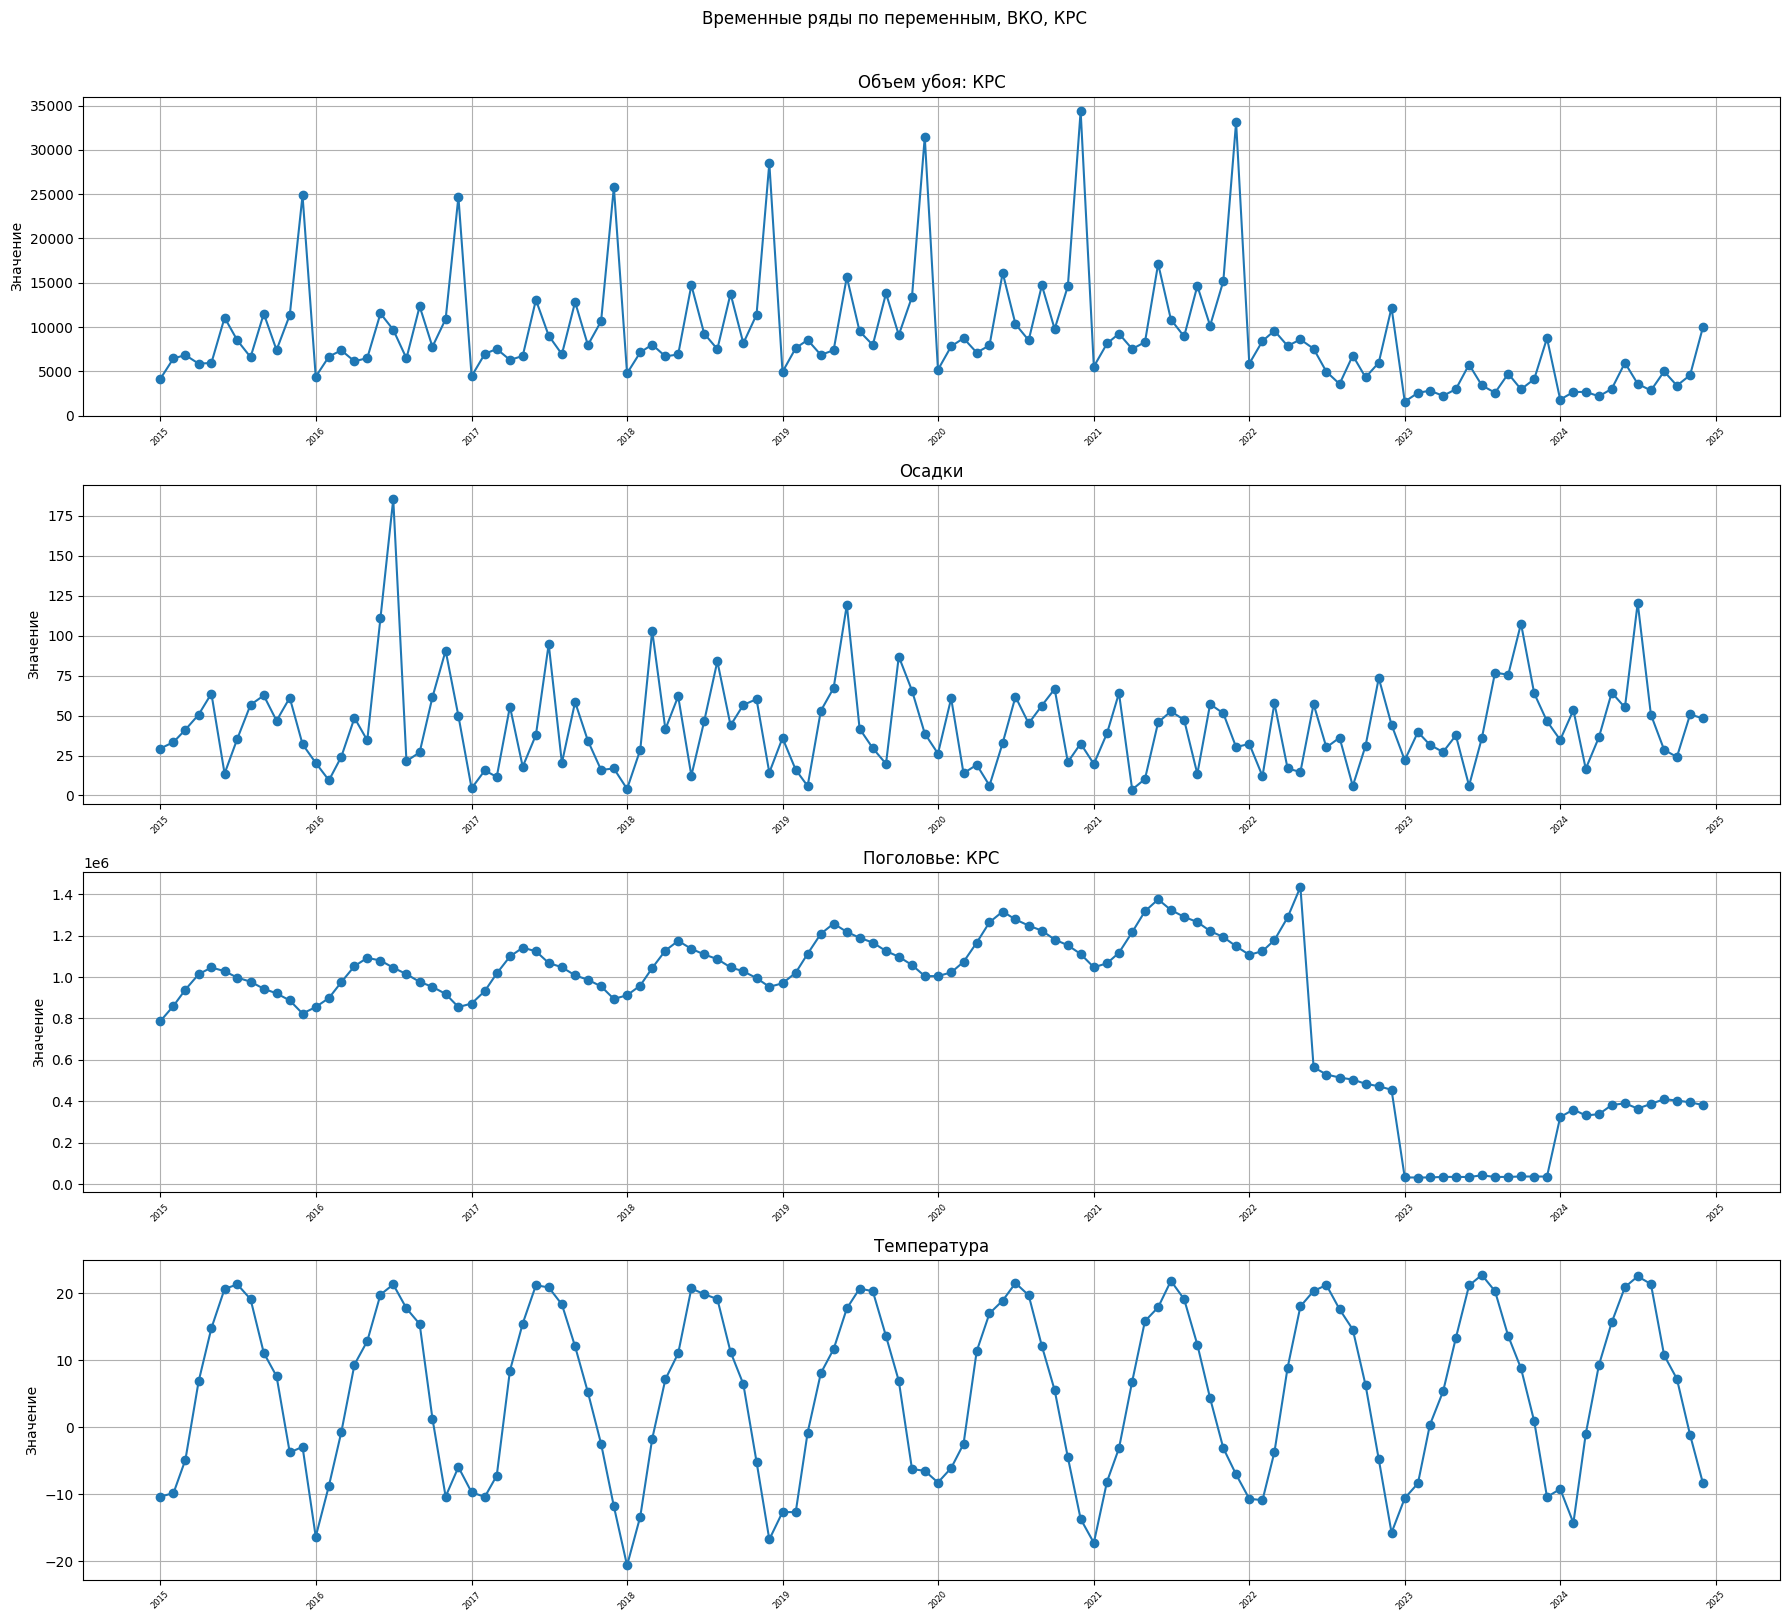

In [9]:
# Plot each variable in its own subplot
value_cols = [col for col in df_vko.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_vko["Период"], df_vko[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, ВКО, КРС", y=1.01)
plt.tight_layout()
plt.show()


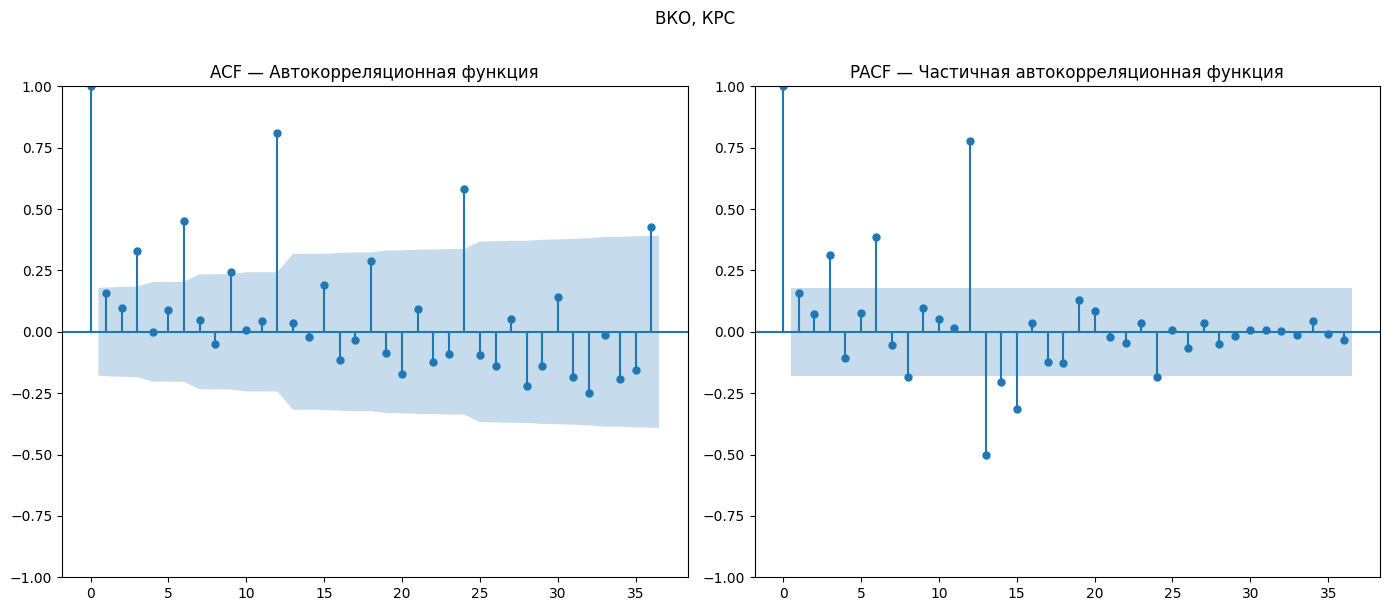

In [10]:
y = df_vko["Объем убоя: КРС"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=36, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=36, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("ВКО, КРС", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями предыдущего месяца** и на возможную **годовую сезонность** (пики на +12, +24 и +36 месяцев). 

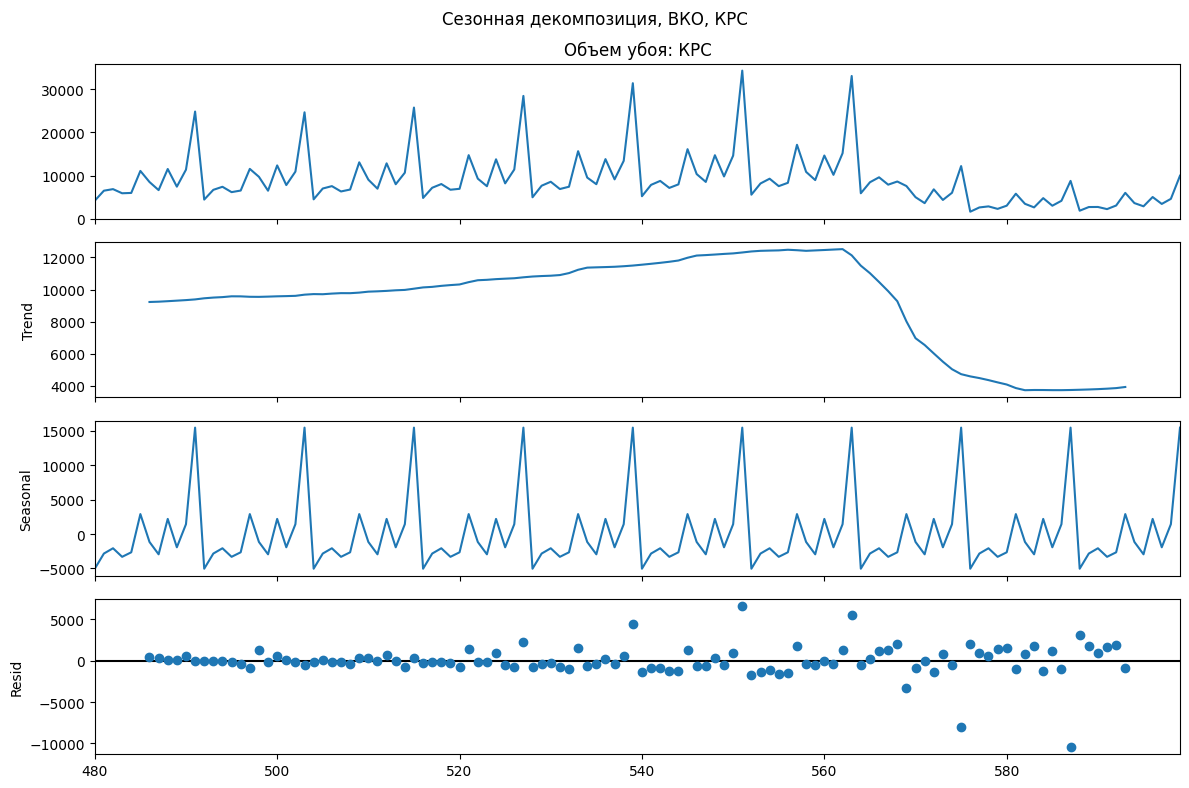

In [11]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_vko["Объем убоя: КРС"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, ВКО, КРС", fontsize=12)
plt.tight_layout()
plt.show()


In [12]:
# Run ADF test
result = adfuller(df_vko["Объем убоя: КРС"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.9433
p-value: 0.7734
Critical Value (1%): -3.4936
Critical Value (5%): -2.8892
Critical Value (10%): -2.5815
❌ The series is likely **non-stationary** (fail to reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [13]:
df_vko

,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
480,2015-01-01,4151.27,29.4,786783.0,-10.364516
481,2015-02-01,6473.64,33.4,860746.0,-9.839286
482,2015-03-01,6837.39,41.2,939284.0,-4.858065
483,2015-04-01,5875.35,50.6,1013296.0,6.830000
484,2015-05-01,5952.33,63.8,1046072.0,14.774194
...,...,...,...,...,...
595,2024-08-01,2845.28,50.6,387497.0,21.361290
596,2024-09-01,5000.88,28.6,410436.0,10.743333
597,2024-10-01,3396.22,24.1,403944.0,7.209677
598,2024-11-01,4578.81,50.7,395279.0,-1.160000


In [14]:
# Создание лагов t-1 до t-4 для переменных
for lag in range(1, 5):
    df_vko[f"КРС_t-{lag}"] = df_vko["Объем убоя: КРС"].shift(lag)
    df_vko[f"Температура_t-{lag}"] = df_vko["Температура"].shift(lag)
    df_vko[f"Осадки_t-{lag}"] = df_vko["Осадки"].shift(lag)
    df_vko[f"Поголовье: КРС_t-{lag}"] = df_vko["Поголовье: КРС"].shift(lag)

# Удаляем строки с NaN после сдвигов
df_vko_lagged = df_vko.dropna().copy()
df_vko_lagged = df_vko_lagged[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]

df_vko_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
484,2015-05-01,5952.33,5875.35,6837.39,6473.64,4151.27,14.774194,6.830000,-4.858065,-9.839286,-10.364516,63.8,50.6,41.2,33.4,29.4,1046072.0,1013296.0,939284.0,860746.0,786783.0
485,2015-06-01,11066.14,5952.33,5875.35,6837.39,6473.64,20.636667,14.774194,6.830000,-4.858065,-9.839286,13.7,63.8,50.6,41.2,33.4,1028143.0,1046072.0,1013296.0,939284.0,860746.0
486,2015-07-01,8491.91,11066.14,5952.33,5875.35,6837.39,21.306452,20.636667,14.774194,6.830000,-4.858065,35.6,13.7,63.8,50.6,41.2,996874.0,1028143.0,1046072.0,1013296.0,939284.0
487,2015-08-01,6608.14,8491.91,11066.14,5952.33,5875.35,19.096774,21.306452,20.636667,14.774194,6.830000,56.8,35.6,13.7,63.8,50.6,977346.0,996874.0,1028143.0,1046072.0,1013296.0
488,2015-09-01,11514.70,6608.14,8491.91,11066.14,5952.33,11.086667,19.096774,21.306452,20.636667,14.774194,62.6,56.8,35.6,13.7,63.8,943328.0,977346.0,996874.0,1028143.0,1046072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-01,2845.28,3593.38,5971.67,3029.97,2194.18,21.361290,22.509677,20.903333,15.641935,9.290000,50.6,120.6,55.1,64.4,36.5,387497.0,365217.0,390491.0,382209.0,338062.0
596,2024-09-01,5000.88,2845.28,3593.38,5971.67,3029.97,10.743333,21.361290,22.509677,20.903333,15.641935,28.6,50.6,120.6,55.1,64.4,410436.0,387497.0,365217.0,390491.0,382209.0
597,2024-10-01,3396.22,5000.88,2845.28,3593.38,5971.67,7.209677,10.743333,21.361290,22.509677,20.903333,24.1,28.6,50.6,120.6,55.1,403944.0,410436.0,387497.0,365217.0,390491.0
598,2024-11-01,4578.81,3396.22,5000.88,2845.28,3593.38,-1.160000,7.209677,10.743333,21.361290,22.509677,50.7,24.1,28.6,50.6,120.6,395279.0,403944.0,410436.0,387497.0,365217.0


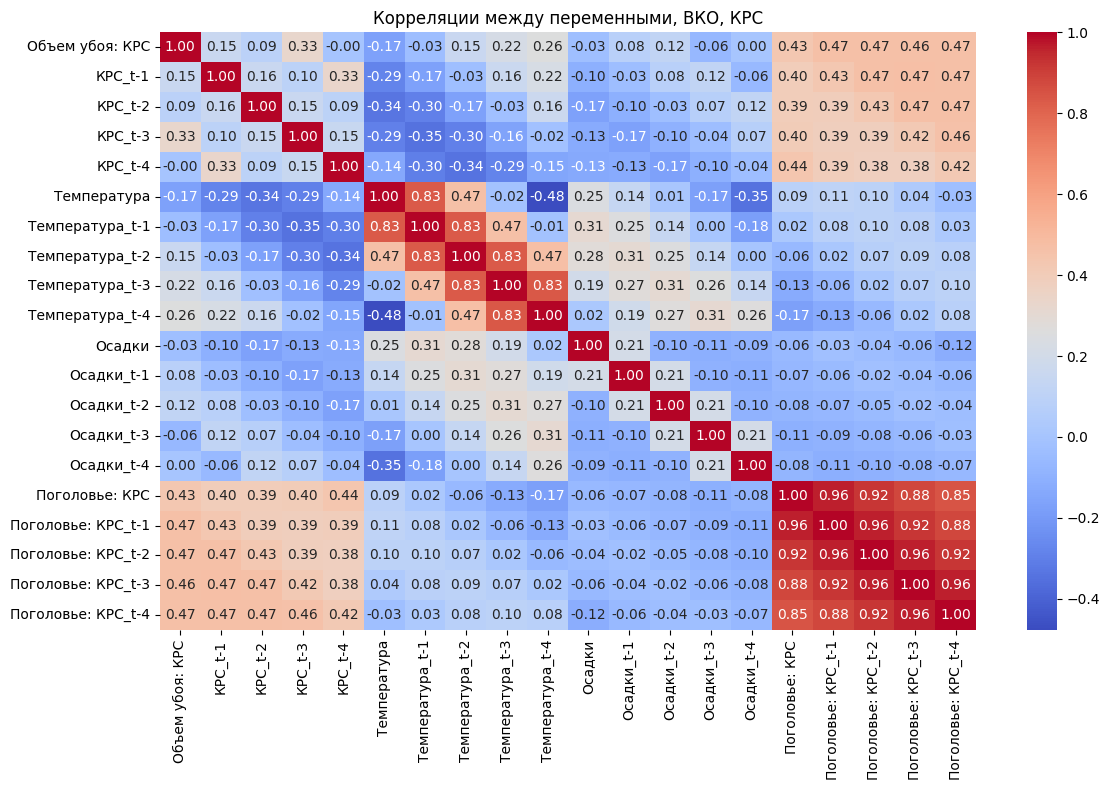

In [15]:
df_corr = df_vko_lagged[[col for col in df_vko_lagged.columns if col not in ["Период"]]].dropna()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, ВКО, КРС")
plt.tight_layout()
plt.show()

<!-- * Умеренная позитивная корреляция (0.51) между показателями объема убоя за все соседствующие временные периоды: между t0 и t-1, t-1 и t-2 так далее. Это свидетельствует о наличии автокорреляции в данных: значения показателя в текущем месяце частично объясняются значениями в соседних месяцах. Это типичный признак временных рядов, особенно в аграрной статистике, где производственные процессы имеют инерционный характер. Это также означает, что модели авторегрессии (AR, ARIMA, SARIMA) могут хорошо работать на этих данных, так как текущие значения "похожи" на недавние;
* Корреляция между значениями обема убоя текущего месяца и предыдущих месяцев постепенно ослабевает, в особенности после лага в t-3. Это может быть связано с тем, что основной объём данных формируется за счёт отчетности крестьянских/фермерских хозяйств и хозяйств населения, которые сдают отчетность ежеквартально. В результате, месячные значения могут быть получены путём декомпозиции квартальных показателей, что сглаживает внутриквартальные различия, но снижает связь между кварталами.
* Температура и осадки, в том числе за предыдущие месяцы, умеренно негативно коррелируют с показателями обема убоя; 
* Между показателями объема убоя и поголовья в рамках значений текущего и предыдущего месяцев отмечается незначительная позитивная корреляция (0.19 и 0.12).

**МОЖНО ЕЩЕ ДОБАВИТЬ ВЫВОДЫ ПРИ НЕОБХОДИМОСТИ** -->

отсечь некоторые регрессоры на данном этапе

### Models

#### Многофакторная регрессия

In [16]:
df_vko = df_vko[["Период",
    "Объем убоя: КРС", "КРС_t-1", "КРС_t-2", "КРС_t-3", "КРС_t-4",
    "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4",
    "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4",
    "Поголовье: КРС", "Поголовье: КРС_t-1", "Поголовье: КРС_t-2", "Поголовье: КРС_t-3", "Поголовье: КРС_t-4"]]
df_vko

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
480,2015-01-01,4151.27,NaN,NaN,NaN,NaN,-10.364516,NaN,NaN,NaN,NaN,29.4,NaN,NaN,NaN,NaN,786783.0,NaN,NaN,NaN,NaN
481,2015-02-01,6473.64,4151.27,NaN,NaN,NaN,-9.839286,-10.364516,NaN,NaN,NaN,33.4,29.4,NaN,NaN,NaN,860746.0,786783.0,NaN,NaN,NaN
482,2015-03-01,6837.39,6473.64,4151.27,NaN,NaN,-4.858065,-9.839286,-10.364516,NaN,NaN,41.2,33.4,29.4,NaN,NaN,939284.0,860746.0,786783.0,NaN,NaN
483,2015-04-01,5875.35,6837.39,6473.64,4151.27,NaN,6.830000,-4.858065,-9.839286,-10.364516,NaN,50.6,41.2,33.4,29.4,NaN,1013296.0,939284.0,860746.0,786783.0,NaN
484,2015-05-01,5952.33,5875.35,6837.39,6473.64,4151.27,14.774194,6.830000,-4.858065,-9.839286,-10.364516,63.8,50.6,41.2,33.4,29.4,1046072.0,1013296.0,939284.0,860746.0,786783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-01,2845.28,3593.38,5971.67,3029.97,2194.18,21.361290,22.509677,20.903333,15.641935,9.290000,50.6,120.6,55.1,64.4,36.5,387497.0,365217.0,390491.0,382209.0,338062.0
596,2024-09-01,5000.88,2845.28,3593.38,5971.67,3029.97,10.743333,21.361290,22.509677,20.903333,15.641935,28.6,50.6,120.6,55.1,64.4,410436.0,387497.0,365217.0,390491.0,382209.0
597,2024-10-01,3396.22,5000.88,2845.28,3593.38,5971.67,7.209677,10.743333,21.361290,22.509677,20.903333,24.1,28.6,50.6,120.6,55.1,403944.0,410436.0,387497.0,365217.0,390491.0
598,2024-11-01,4578.81,3396.22,5000.88,2845.28,3593.38,-1.160000,7.209677,10.743333,21.361290,22.509677,50.7,24.1,28.6,50.6,120.6,395279.0,403944.0,410436.0,387497.0,365217.0


In [17]:
df_vko_lagged

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
484,2015-05-01,5952.33,5875.35,6837.39,6473.64,4151.27,14.774194,6.830000,-4.858065,-9.839286,-10.364516,63.8,50.6,41.2,33.4,29.4,1046072.0,1013296.0,939284.0,860746.0,786783.0
485,2015-06-01,11066.14,5952.33,5875.35,6837.39,6473.64,20.636667,14.774194,6.830000,-4.858065,-9.839286,13.7,63.8,50.6,41.2,33.4,1028143.0,1046072.0,1013296.0,939284.0,860746.0
486,2015-07-01,8491.91,11066.14,5952.33,5875.35,6837.39,21.306452,20.636667,14.774194,6.830000,-4.858065,35.6,13.7,63.8,50.6,41.2,996874.0,1028143.0,1046072.0,1013296.0,939284.0
487,2015-08-01,6608.14,8491.91,11066.14,5952.33,5875.35,19.096774,21.306452,20.636667,14.774194,6.830000,56.8,35.6,13.7,63.8,50.6,977346.0,996874.0,1028143.0,1046072.0,1013296.0
488,2015-09-01,11514.70,6608.14,8491.91,11066.14,5952.33,11.086667,19.096774,21.306452,20.636667,14.774194,62.6,56.8,35.6,13.7,63.8,943328.0,977346.0,996874.0,1028143.0,1046072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-01,2845.28,3593.38,5971.67,3029.97,2194.18,21.361290,22.509677,20.903333,15.641935,9.290000,50.6,120.6,55.1,64.4,36.5,387497.0,365217.0,390491.0,382209.0,338062.0
596,2024-09-01,5000.88,2845.28,3593.38,5971.67,3029.97,10.743333,21.361290,22.509677,20.903333,15.641935,28.6,50.6,120.6,55.1,64.4,410436.0,387497.0,365217.0,390491.0,382209.0
597,2024-10-01,3396.22,5000.88,2845.28,3593.38,5971.67,7.209677,10.743333,21.361290,22.509677,20.903333,24.1,28.6,50.6,120.6,55.1,403944.0,410436.0,387497.0,365217.0,390491.0
598,2024-11-01,4578.81,3396.22,5000.88,2845.28,3593.38,-1.160000,7.209677,10.743333,21.361290,22.509677,50.7,24.1,28.6,50.6,120.6,395279.0,403944.0,410436.0,387497.0,365217.0


In [18]:
df_vif = df_vko_lagged[[col for col in df_vko_lagged.columns if col not in ["Период"]]]

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,29.883663
1,КРС_t-1,2.047419
2,КРС_t-2,2.158194
3,КРС_t-3,2.136852
4,КРС_t-4,1.991941
5,Температура,13.618569
6,Температура_t-1,18.275894
7,Температура_t-2,17.835914
8,Температура_t-3,18.821626
9,Температура_t-4,12.793358


In [19]:
def forward_selection(data, target, candidate_features, criterion="adj_r2"):
    remaining = list(candidate_features)
    selected = []
    best_score = -float("inf")
    best_model = None

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            X = sm.add_constant(data[features])
            y = data[target]
            model = sm.OLS(y, X).fit()

            if criterion == "adj_r2":
                score = model.rsquared_adj
            elif criterion == "aic":
                score = -model.aic  # negative for maximizing
            else:
                raise ValueError("criterion must be 'adj_r2' or 'aic'")

            scores_with_candidates.append((score, candidate, model))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate, model = scores_with_candidates[0]

        if best_new_score > best_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_score = best_new_score
            best_model = model
            print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
        else:
            print("⛔ No improvement. Stopping.")
            break

    return selected, best_model


In [20]:
# Define target and candidate predictors
target = "Объем убоя: КРС"
candidate_features = ['Осадки', 'Осадки_t-3', 'Осадки_t-2', 'Осадки_t-1',
    'Температура', 'Температура_t-3', 'Температура_t-2', 'Температура_t-1',
    'Поголовье: КРС', 'Поголовье: КРС_t-3', 'Поголовье: КРС_t-2', 'Поголовье: КРС_t-1',
    'КРС_t-4', 'КРС_t-3', 'КРС_t-2', 'КРС_t-1']

# Drop rows with missing values
df_mlr = df_vko[candidate_features + [target]].dropna()

# Run forward selection
selected_features, final_model = forward_selection(df_mlr, target, candidate_features, criterion="adj_r2")

# Show final summary

print(selected_features)
print("\n🧾 Final Model Summary:")
print(final_model.summary())



✅ Added: Поголовье: КРС_t-2, ADJ_R2: 0.2119
✅ Added: Температура, ADJ_R2: 0.2515
✅ Added: Температура_t-2, ADJ_R2: 0.3082
✅ Added: КРС_t-2, ADJ_R2: 0.3524
✅ Added: КРС_t-1, ADJ_R2: 0.4187
✅ Added: КРС_t-4, ADJ_R2: 0.4451
✅ Added: Температура_t-1, ADJ_R2: 0.4642
✅ Added: Поголовье: КРС_t-1, ADJ_R2: 0.4748
✅ Added: Осадки_t-2, ADJ_R2: 0.4779
✅ Added: Осадки_t-3, ADJ_R2: 0.4825
⛔ No improvement. Stopping.
['Поголовье: КРС_t-2', 'Температура', 'Температура_t-2', 'КРС_t-2', 'КРС_t-1', 'КРС_t-4', 'Температура_t-1', 'Поголовье: КРС_t-1', 'Осадки_t-2', 'Осадки_t-3']

🧾 Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     11.72
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.54e-13
Time:           

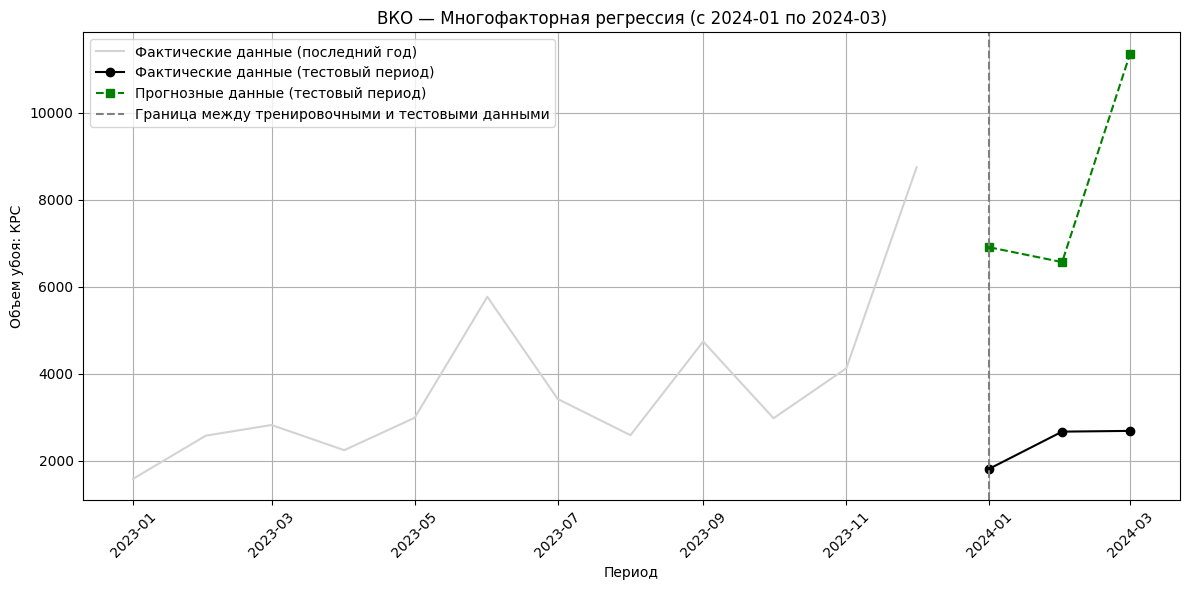

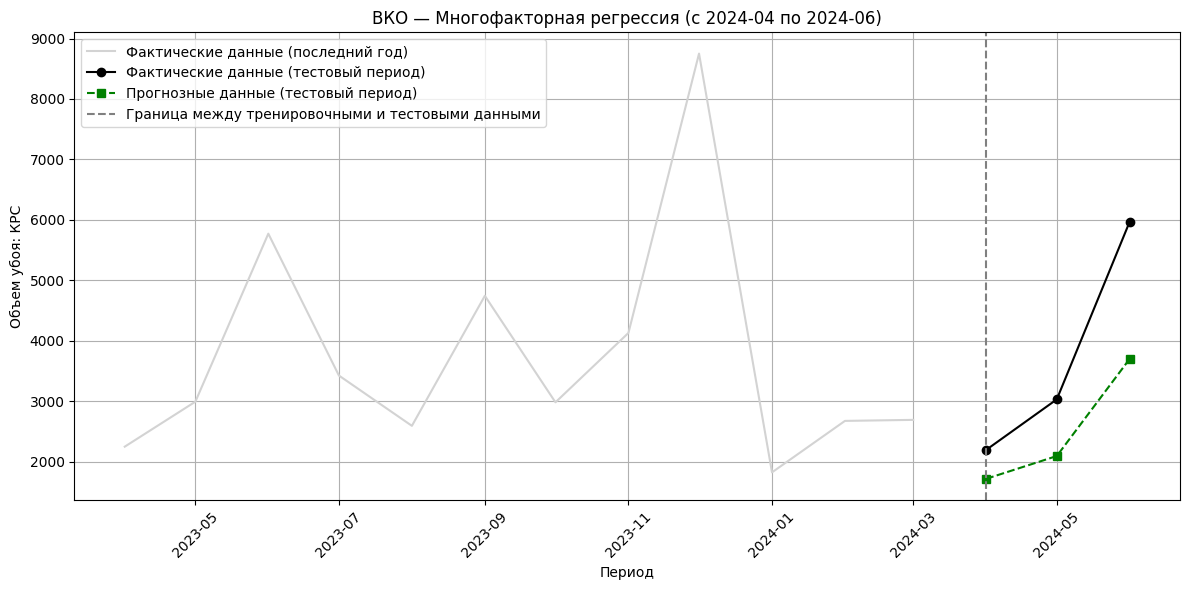

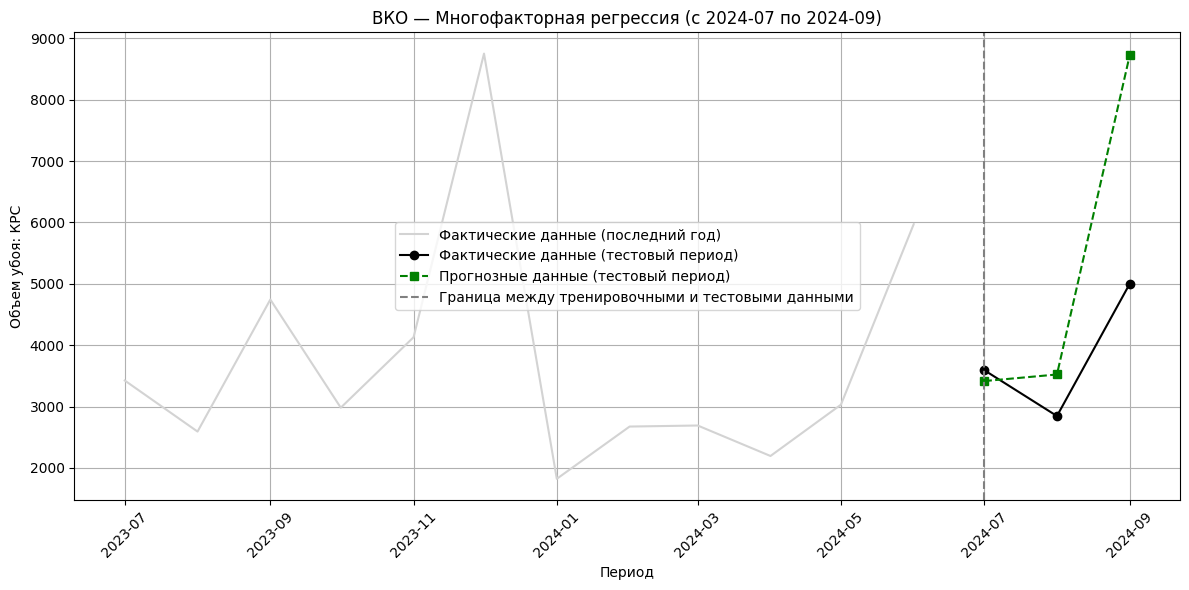

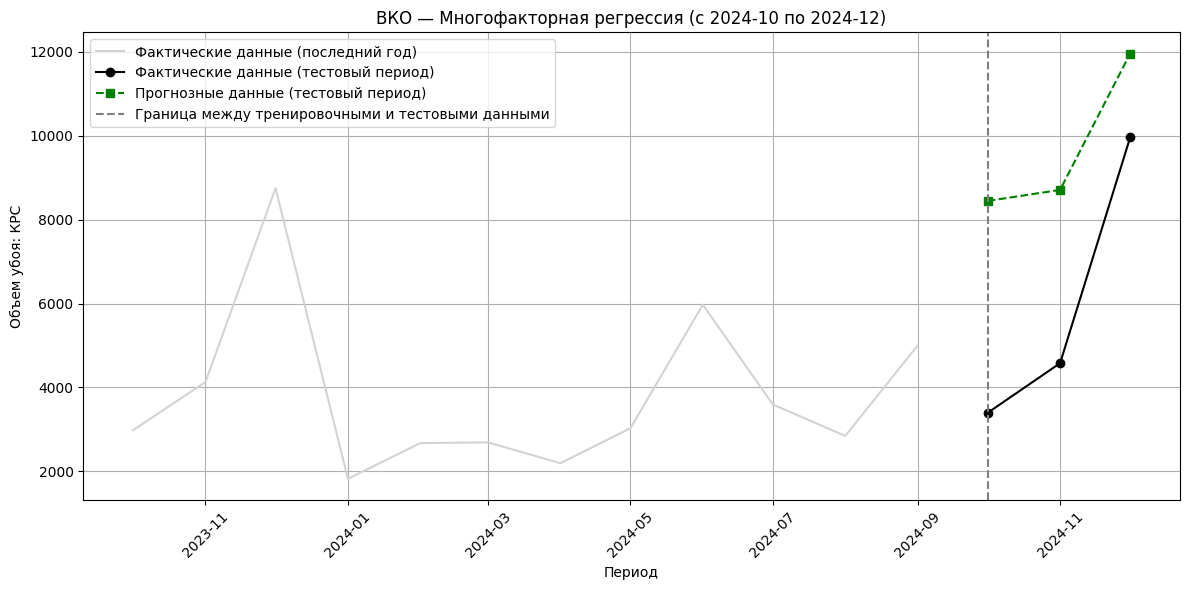

In [21]:
# Ensure your dataframe is sorted by time
df = df_vko.sort_values("Период").dropna().copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [22]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE    MAPE (%)          R²
0  2024-01 to 2024-03  6223.515061  5883.637626  249.000726 -234.569227
1  2024-04 to 2024-06  1444.716120  1228.754913   30.256284    0.204759
2  2024-07 to 2024-09  2187.719575  1526.453739   34.407580   -4.993200
3  2024-10 to 2024-12  3939.630734  3726.768729   86.328002   -0.903063
4             Average  3448.895373  3091.403752   99.998148  -60.065183


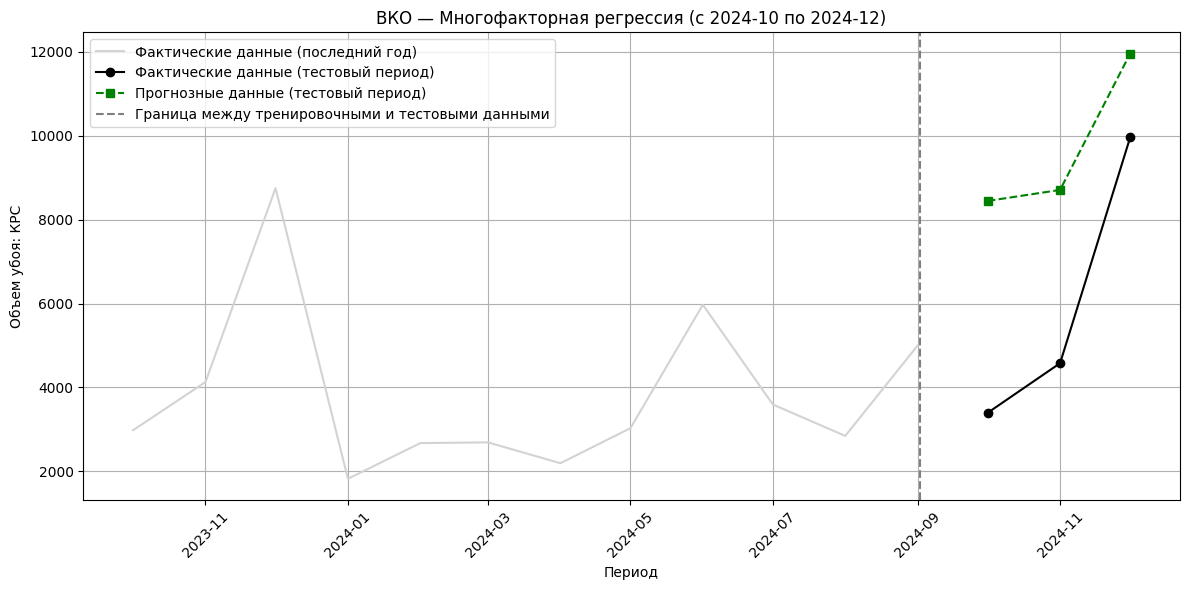

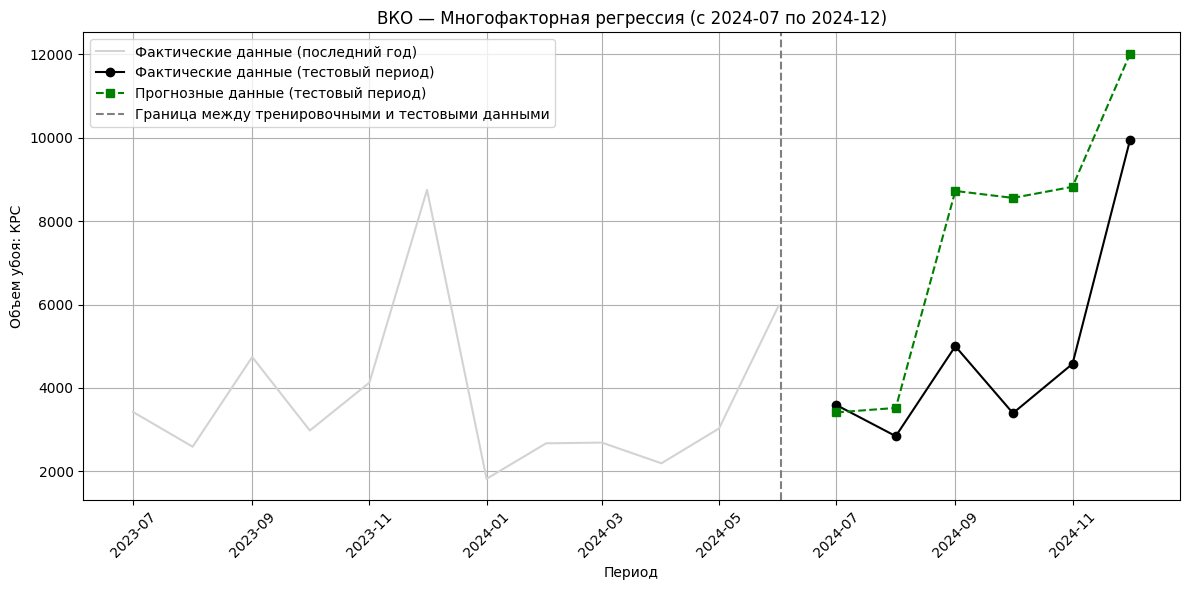

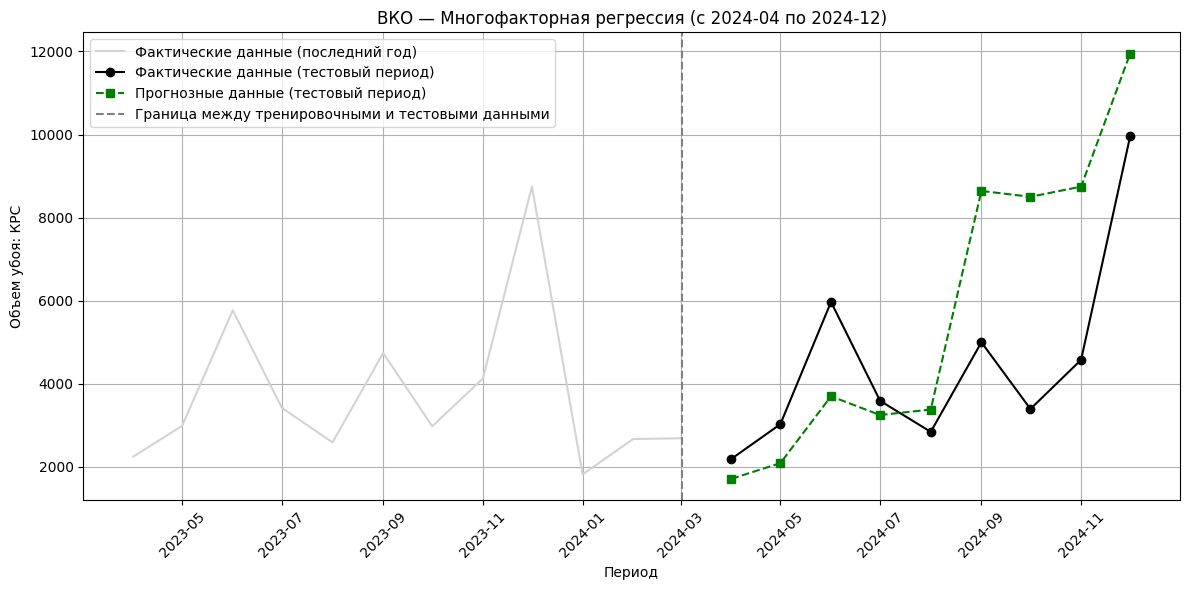

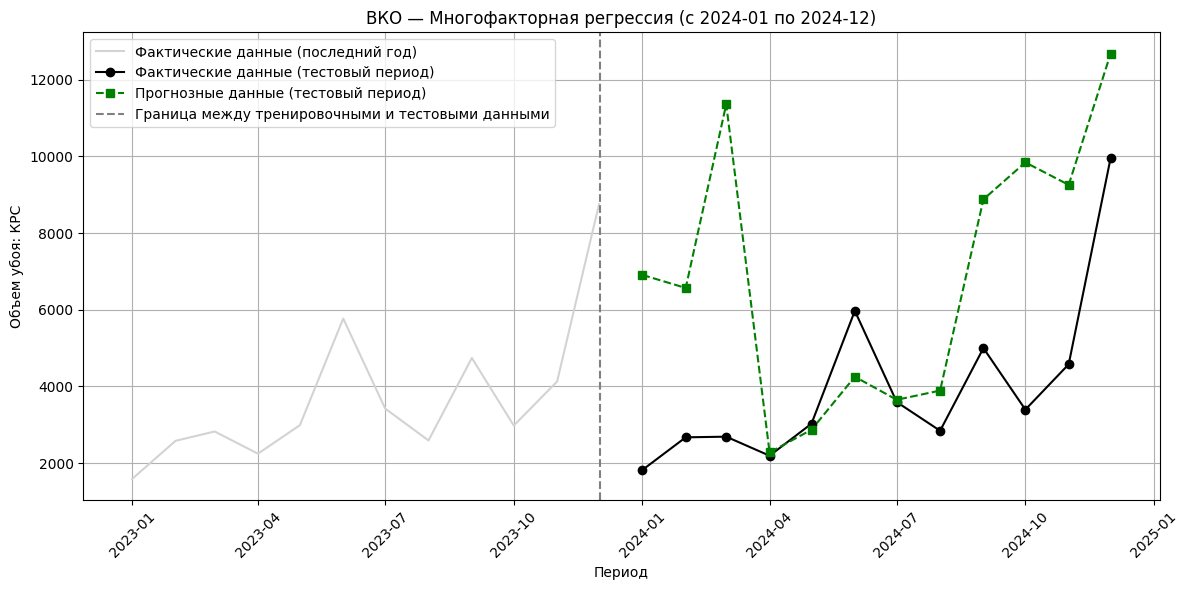

In [23]:
# Ensure your dataframe is sorted by time
df = df_vko.sort_values("Период").dropna().copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE    MAPE (%)        R²
0  2024-10 to 2024-12  3939.630734  3726.768729   86.328002 -0.903063
1  2024-07 to 2024-12  3247.369518  2674.499534   61.436837 -0.866933
2  2024-04 to 2024-12  2735.234482  2163.650044   50.376777 -0.514043
3  2024-01 to 2024-12  4145.257743  3203.992306  101.693609 -2.748890
4             Average  3516.873120  2942.227653   74.958806 -1.258233


In [25]:
df_vko

,Период,Объем убоя: КРС,КРС_t-1,КРС_t-2,КРС_t-3,КРС_t-4,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Поголовье: КРС,Поголовье: КРС_t-1,Поголовье: КРС_t-2,Поголовье: КРС_t-3,Поголовье: КРС_t-4
480,2015-01-01,4151.27,NaN,NaN,NaN,NaN,-10.364516,NaN,NaN,NaN,NaN,29.4,NaN,NaN,NaN,NaN,786783.0,NaN,NaN,NaN,NaN
481,2015-02-01,6473.64,4151.27,NaN,NaN,NaN,-9.839286,-10.364516,NaN,NaN,NaN,33.4,29.4,NaN,NaN,NaN,860746.0,786783.0,NaN,NaN,NaN
482,2015-03-01,6837.39,6473.64,4151.27,NaN,NaN,-4.858065,-9.839286,-10.364516,NaN,NaN,41.2,33.4,29.4,NaN,NaN,939284.0,860746.0,786783.0,NaN,NaN
483,2015-04-01,5875.35,6837.39,6473.64,4151.27,NaN,6.830000,-4.858065,-9.839286,-10.364516,NaN,50.6,41.2,33.4,29.4,NaN,1013296.0,939284.0,860746.0,786783.0,NaN
484,2015-05-01,5952.33,5875.35,6837.39,6473.64,4151.27,14.774194,6.830000,-4.858065,-9.839286,-10.364516,63.8,50.6,41.2,33.4,29.4,1046072.0,1013296.0,939284.0,860746.0,786783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-01,2845.28,3593.38,5971.67,3029.97,2194.18,21.361290,22.509677,20.903333,15.641935,9.290000,50.6,120.6,55.1,64.4,36.5,387497.0,365217.0,390491.0,382209.0,338062.0
596,2024-09-01,5000.88,2845.28,3593.38,5971.67,3029.97,10.743333,21.361290,22.509677,20.903333,15.641935,28.6,50.6,120.6,55.1,64.4,410436.0,387497.0,365217.0,390491.0,382209.0
597,2024-10-01,3396.22,5000.88,2845.28,3593.38,5971.67,7.209677,10.743333,21.361290,22.509677,20.903333,24.1,28.6,50.6,120.6,55.1,403944.0,410436.0,387497.0,365217.0,390491.0
598,2024-11-01,4578.81,3396.22,5000.88,2845.28,3593.38,-1.160000,7.209677,10.743333,21.361290,22.509677,50.7,24.1,28.6,50.6,120.6,395279.0,403944.0,410436.0,387497.0,365217.0


#### SARIMA (auto-arima)

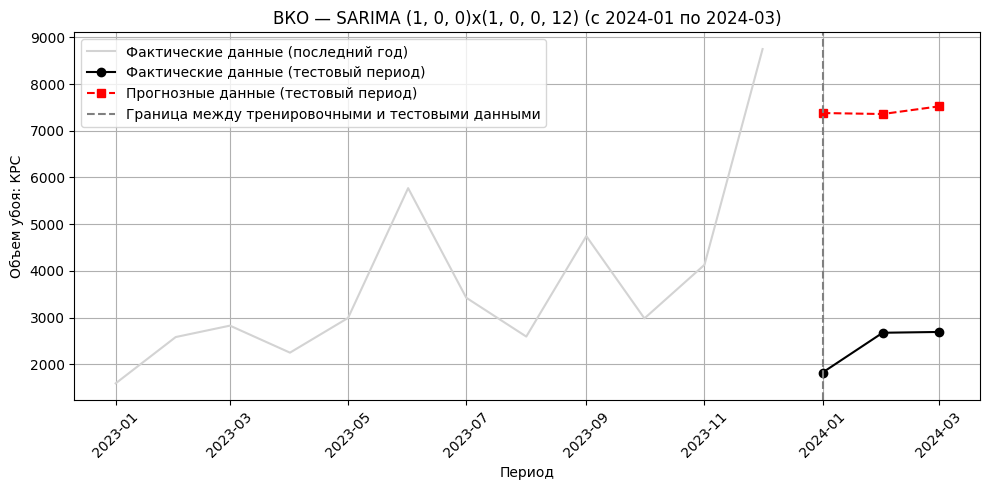

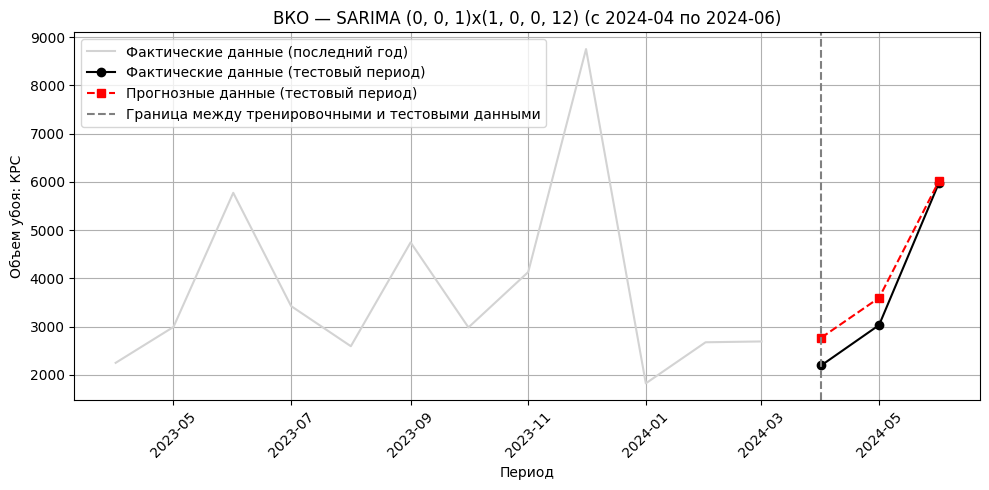

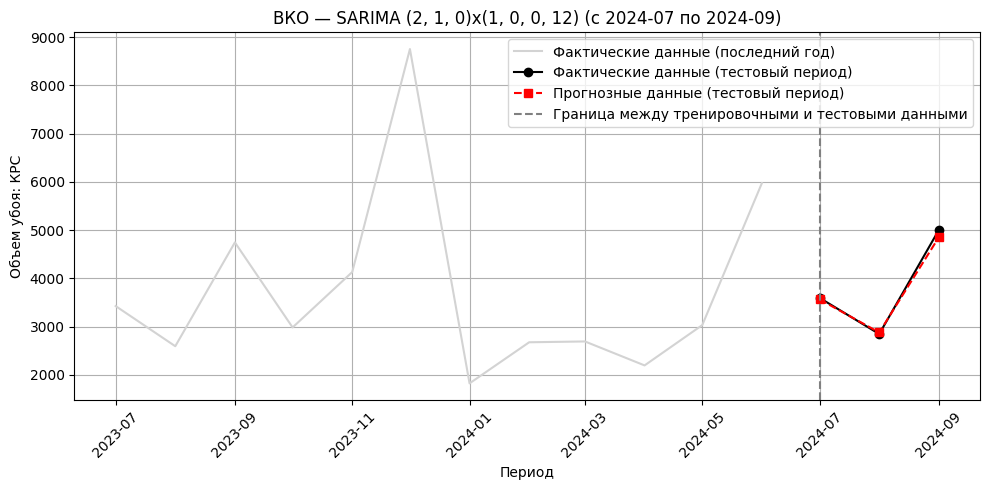

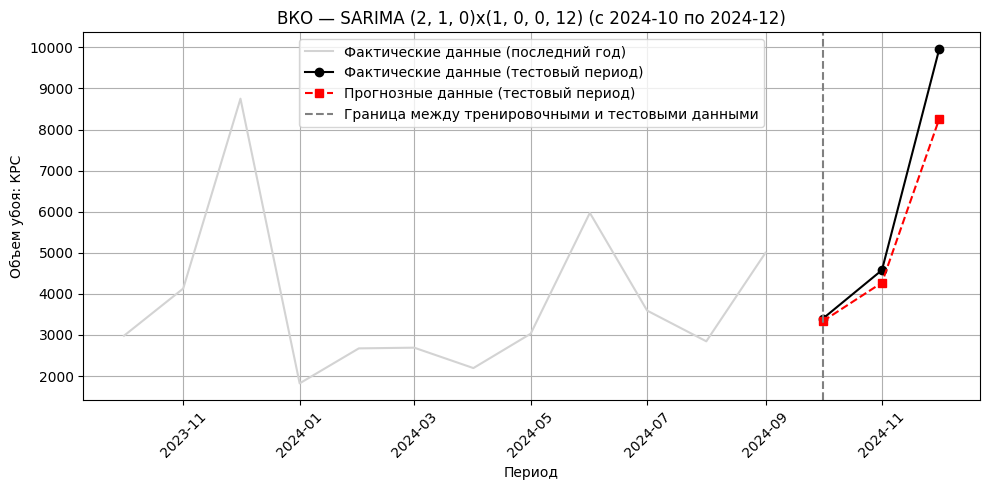

In [26]:
df = df_vko.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [27]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE    MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  5039.505377  5025.040227  219.934231    (1, 0, 0)   
1  2024-04 to 2024-06   465.414256   392.152584   15.144279    (0, 0, 1)   
2  2024-07 to 2024-09    90.503571    70.902820    1.657108    (2, 1, 0)   
3  2024-10 to 2024-12   997.451554   689.056378    8.523575    (2, 1, 0)   
4             Average  1648.218689  1544.288002   61.314798          NaN   

  Seasonal order  
0  (1, 0, 0, 12)  
1  (1, 0, 0, 12)  
2  (1, 0, 0, 12)  
3  (1, 0, 0, 12)  
4            NaN  


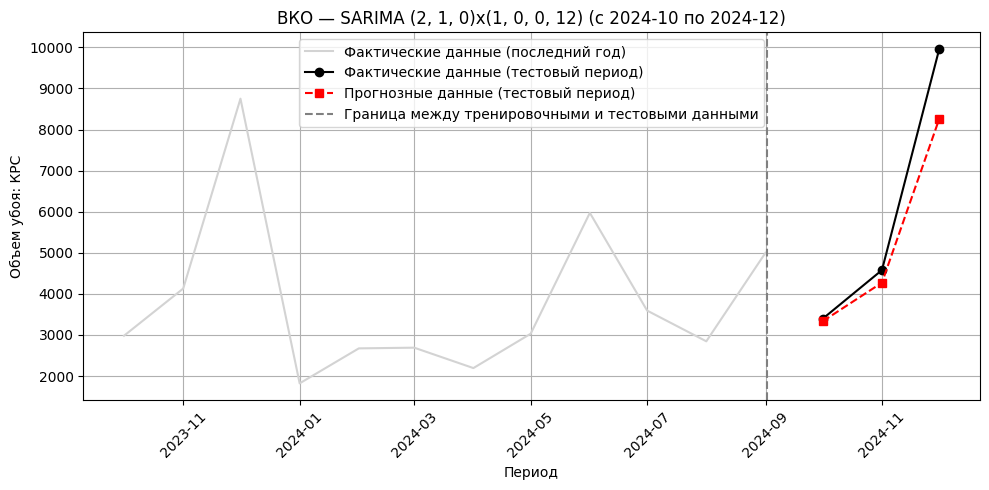

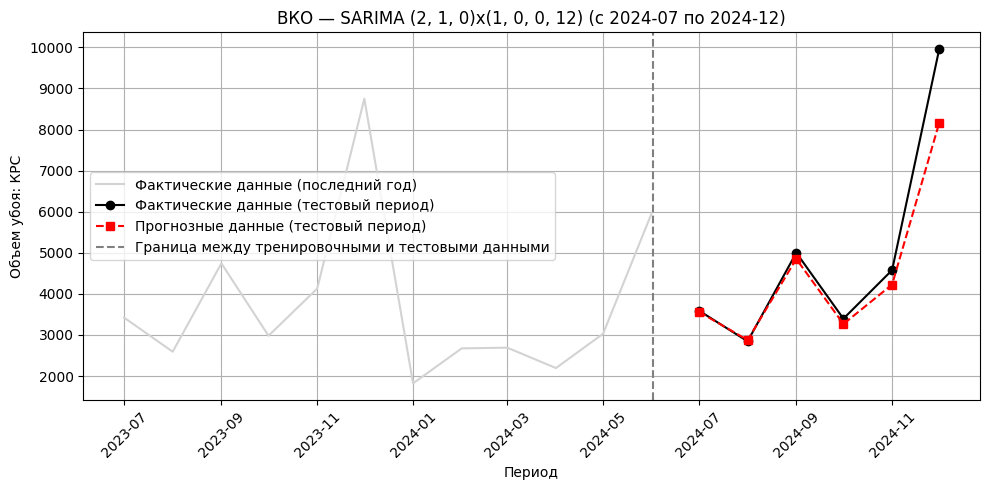

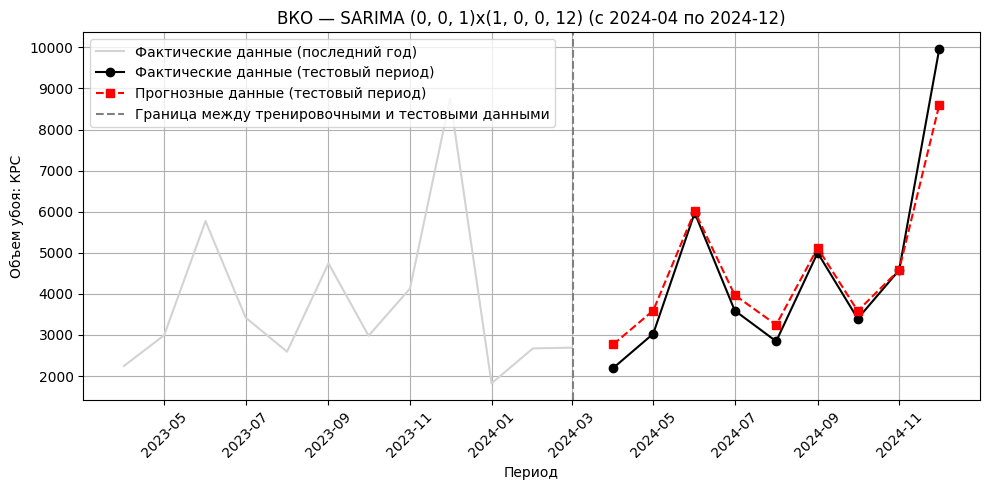

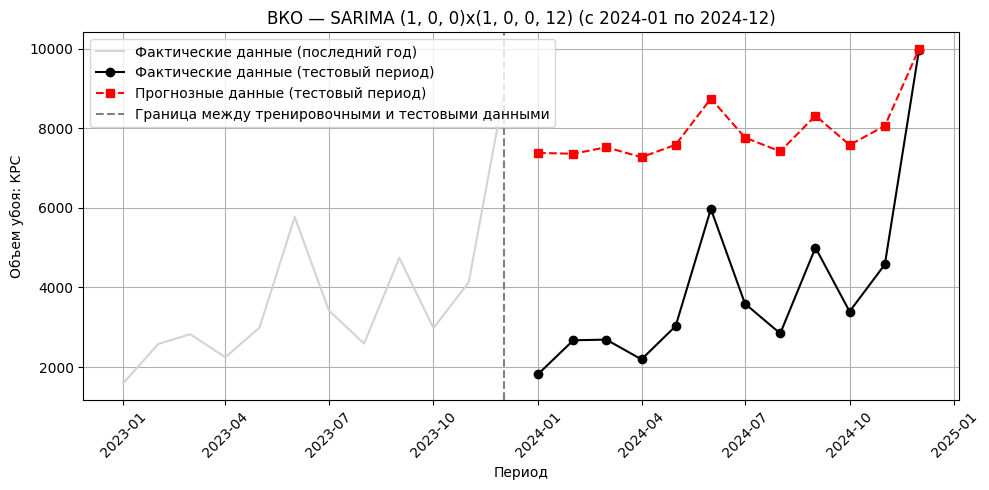

In [28]:
df = df_vko.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [29]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE    MAPE (%) SARIMA order  \
0  2024-10 to 2024-12   997.451554   689.056378    8.523575    (2, 1, 0)   
1  2024-07 to 2024-12   752.213797   415.236658    5.753767    (2, 1, 0)   
2  2024-04 to 2024-12   563.247508   402.830036   10.188738    (0, 0, 1)   
3  2024-01 to 2024-12  4176.594161  3936.196028  135.881647    (1, 0, 0)   
4             Average  1622.376755  1360.829775   40.086932          NaN   

  Seasonal order  
0  (1, 0, 0, 12)  
1  (1, 0, 0, 12)  
2  (1, 0, 0, 12)  
3  (1, 0, 0, 12)  
4            NaN  


#### SARIMAX

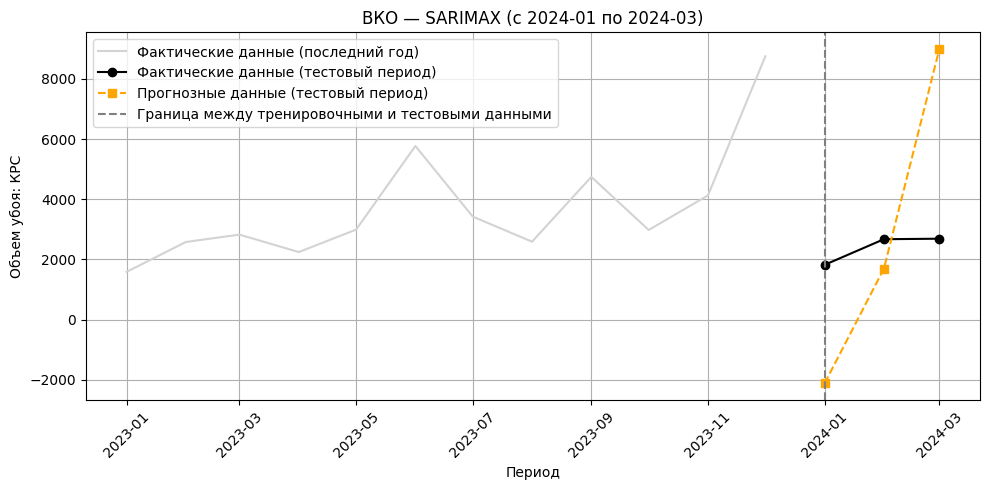

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


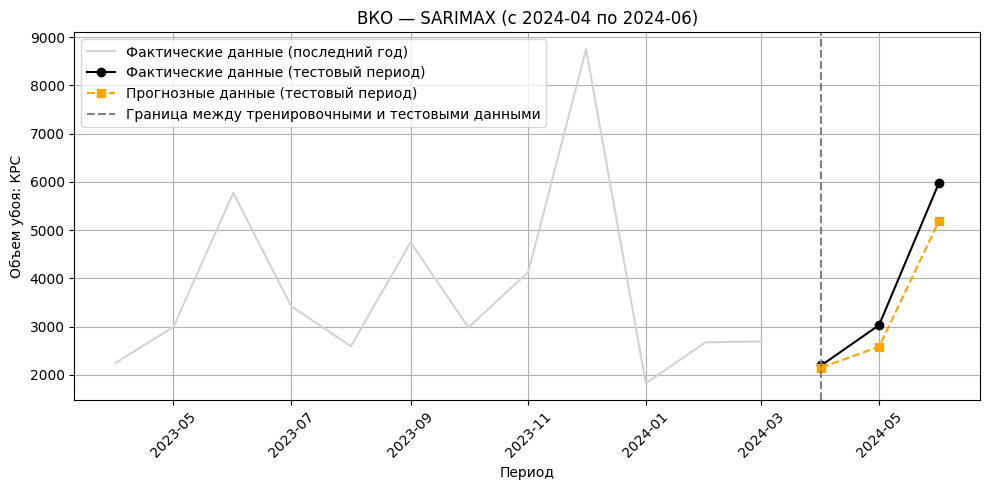

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


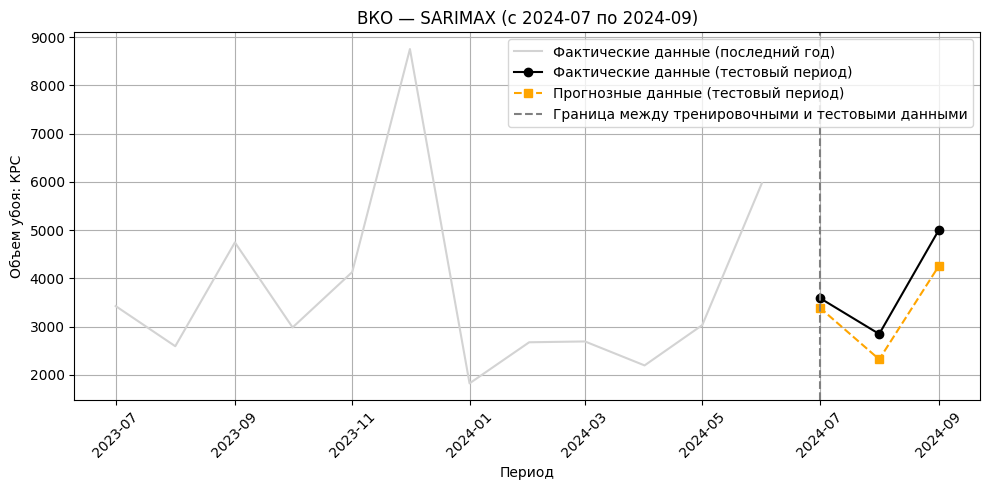

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


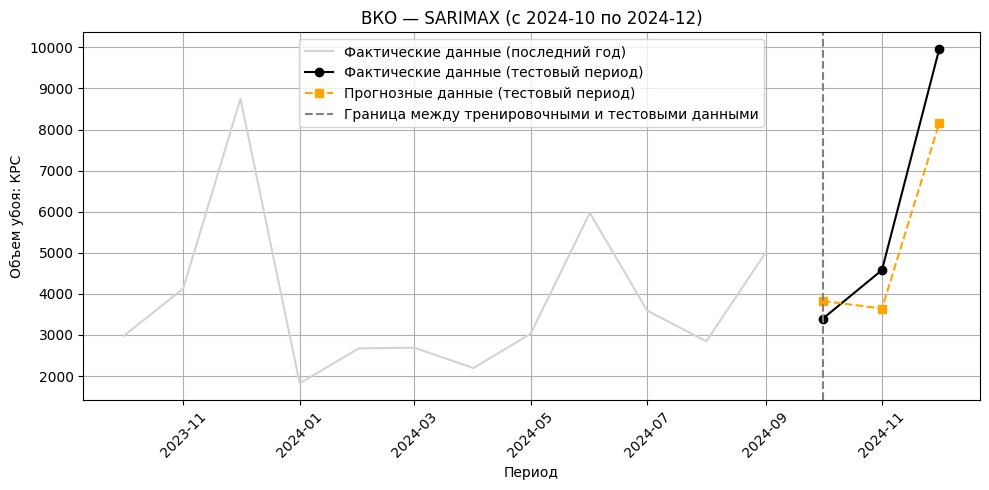

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-1']

df = df_vko.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 0, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [35]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



          Test period         RMSE          MAE    MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  4326.141064  3737.934147  162.237803            0   
1  2024-04 to 2024-06   527.131570   429.069275   10.044345            0   
2  2024-07 to 2024-09   538.932434   490.024409   12.972193            0   
3  2024-10 to 2024-12  1202.351893  1058.593146   17.090827            0   
4             Average  1648.639240  1428.905244   50.586292                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


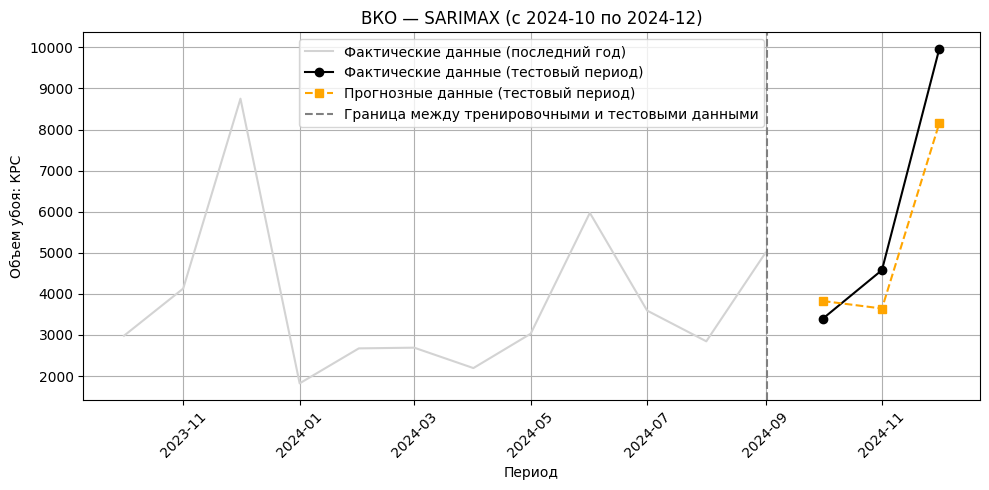

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


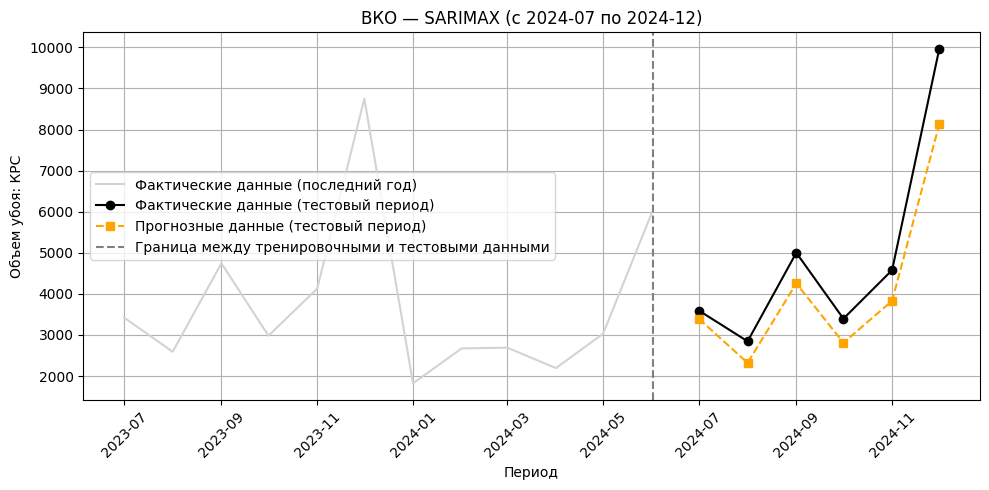

c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


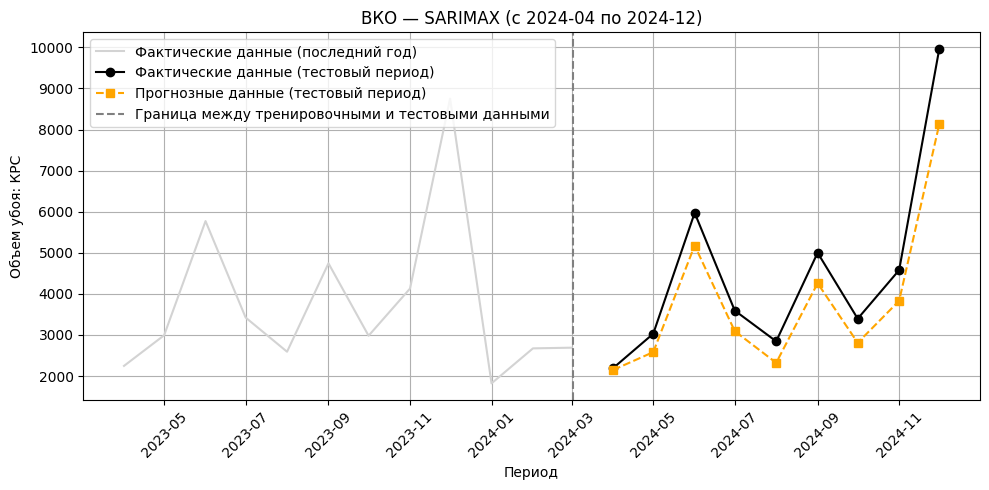

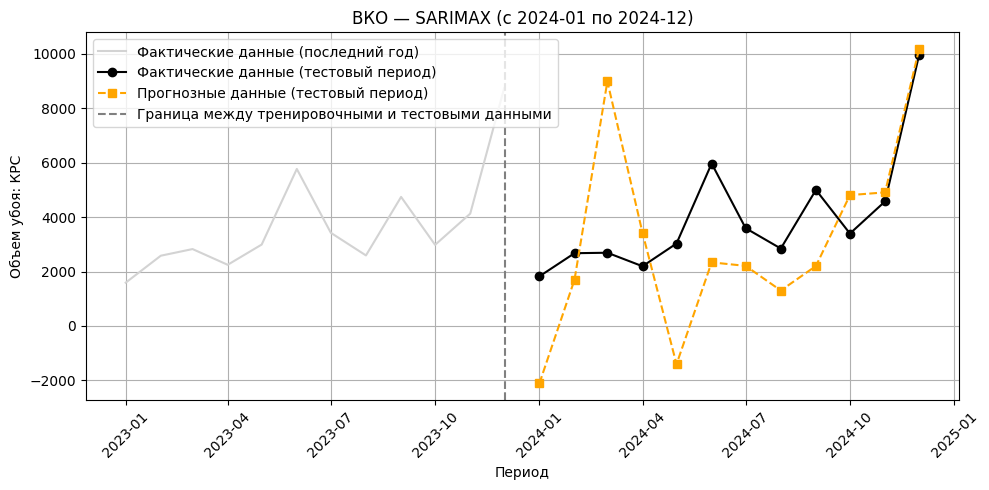

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-1']

df = df_vko.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 0, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [37]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  1202.351893  1058.593146  17.090827            0   
1  2024-07 to 2024-12   925.596184   773.122882  15.154874            0   
2  2024-04 to 2024-12   828.330375   691.211673  14.366128            0   
3  2024-01 to 2024-12  2955.872528  2350.617922  79.153076            0   
4             Average  1478.037745  1218.386406  31.441226                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


#### Prophet

18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing


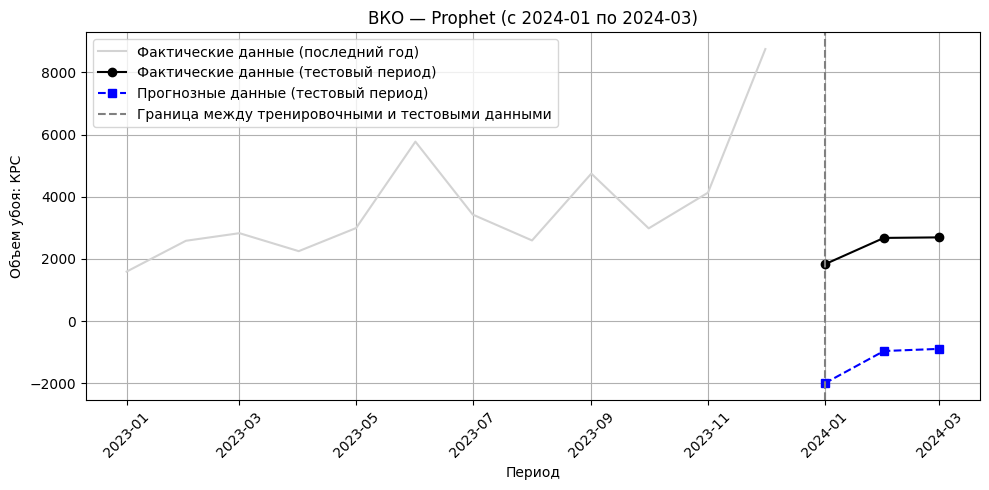

18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing


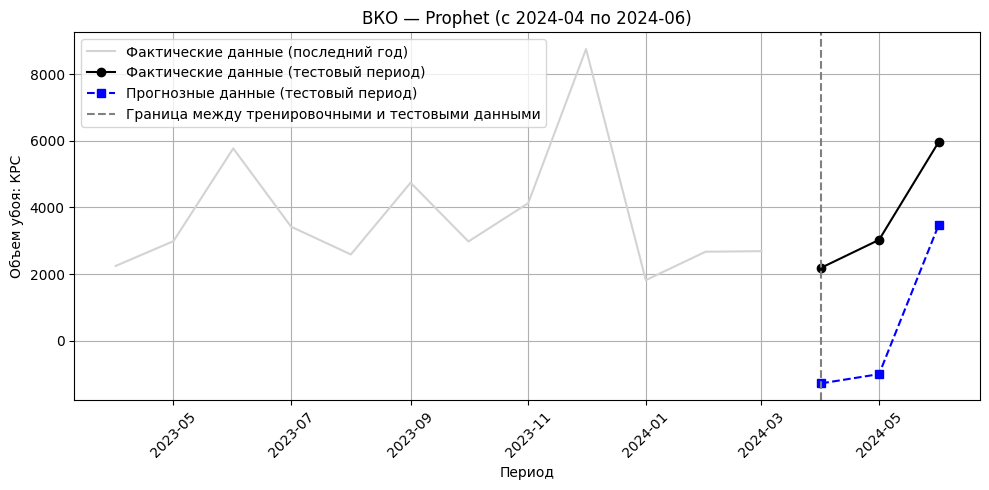

18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing


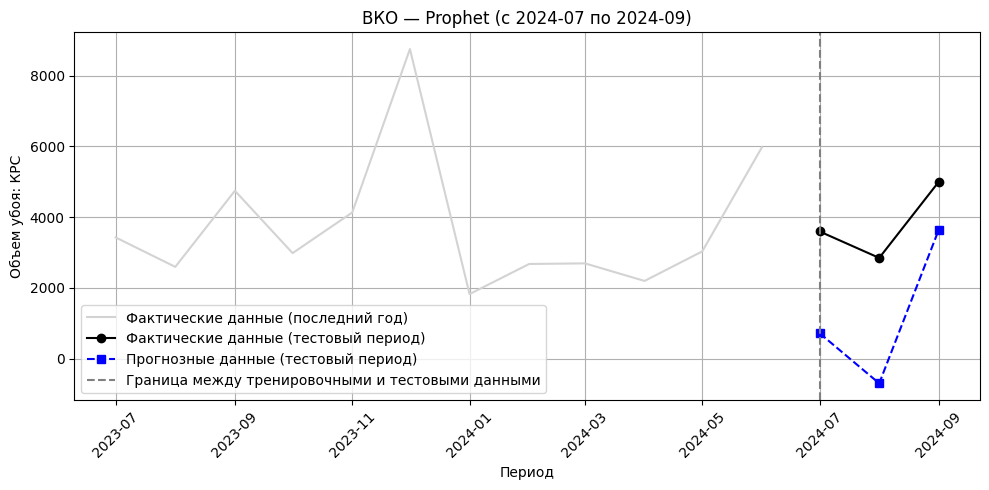

18:28:37 - cmdstanpy - INFO - Chain [1] start processing
18:28:37 - cmdstanpy - INFO - Chain [1] done processing


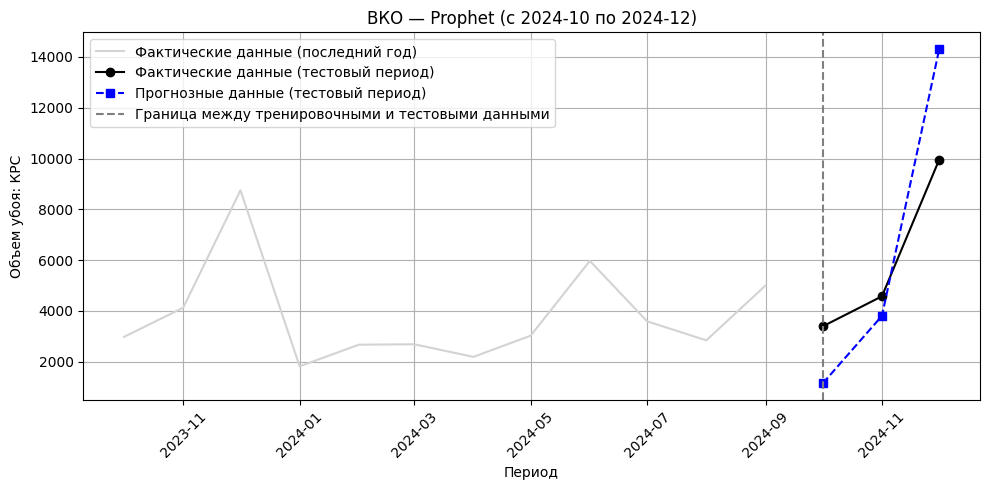

In [38]:
# Prepare Data
df = df_vko.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура")
    # model.add_regressor("Осадки")
    # model.add_regressor("Поголовье: КРС")
    # prophet_train["Температура"] = train_df["Температура"].values
    # prophet_test["Температура"] = test_df["Температура"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [39]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period         RMSE          MAE    MAPE (%)
0  2024-01 to 2024-03  3686.737602  3685.281368  159.851237
1  2024-04 to 2024-06  3386.159998  3325.600413  110.825955
2  2024-07 to 2024-09  2750.144641  2592.374920   77.261825
3  2024-10 to 2024-12  2860.000392  2454.354327   42.187972
4             Average  3170.760658  3014.402757   97.531747


18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing



🔹 Прогноз на 3 месяцев


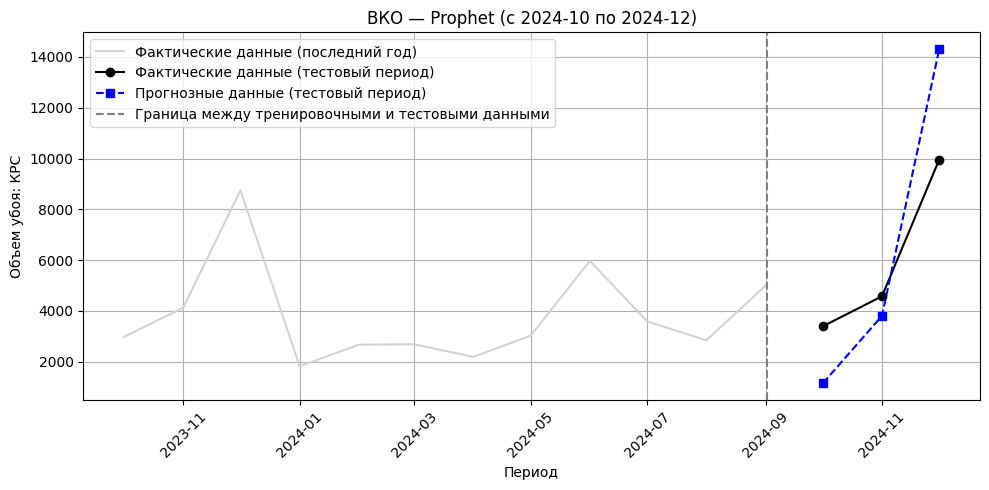

18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing



🔹 Прогноз на 6 месяцев


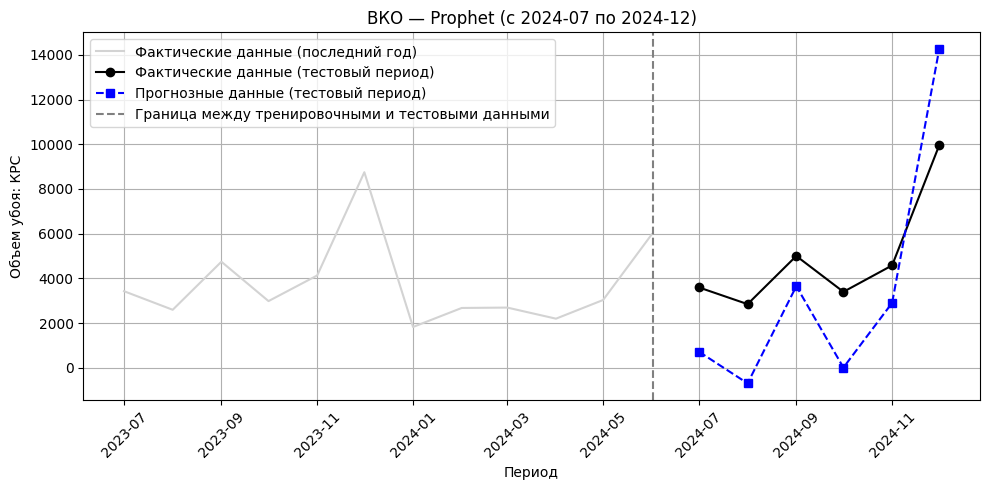

18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing



🔹 Прогноз на 9 месяцев


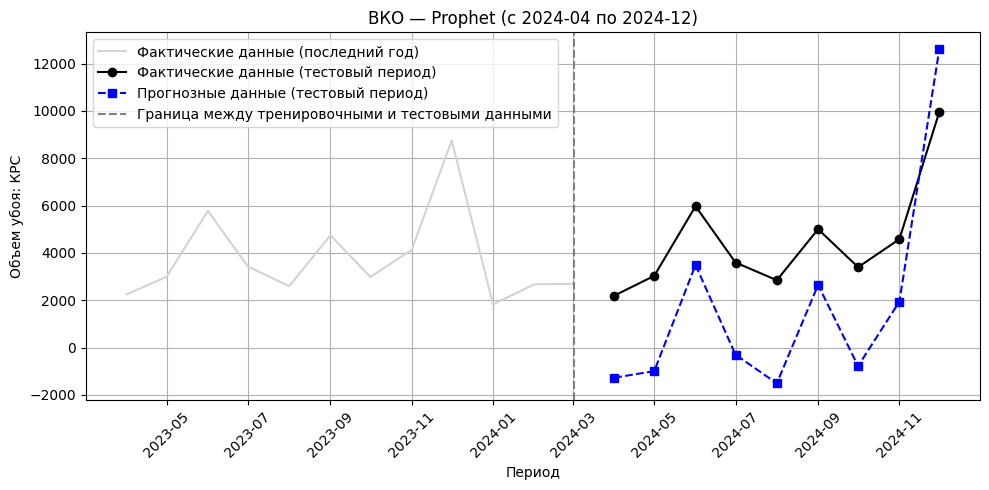

18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing



🔹 Прогноз на 12 месяцев


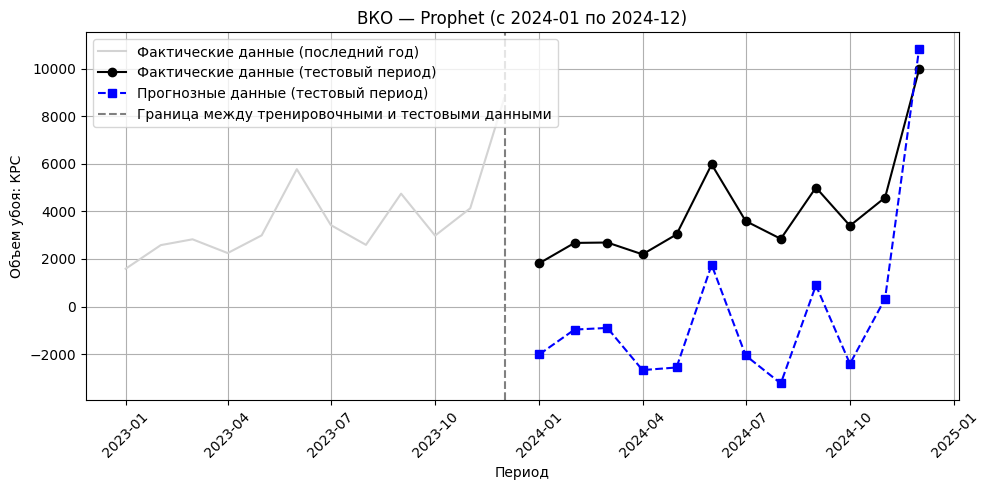

In [40]:
# Prepare data
df = df_vko.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])
target = "Объем убоя: КРС"

# Define forecast horizons
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:
    print(f"\n🔹 Прогноз на {horizon} месяцев")

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [41]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Horizon (months)"] = "Среднее"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period         RMSE          MAE    MAPE (%) Horizon (months)
0  2024-10 to 2024-12  2860.000392  2454.354327   42.187972              NaN
1  2024-07 to 2024-12  3042.756349  2858.773602   68.587340              NaN
2  2024-04 to 2024-12  3424.412487  3338.887499   94.257750              NaN
3  2024-01 to 2024-12  4577.794007  4371.264308  140.086729              NaN
4                 NaN  3476.240809  3255.819934   86.279948          Среднее


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation